In [62]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from numba import jit

### Introdução
A atividade a ser explorada neste trabalho diz respeito ao processo de termalização. Aqui será apresentada uma simulação do modelo de Ising 2D com base no algoritmo de Metropolis. 
O modelo de Ising 2D pode ser entendido como um grid de pontos, no qual cada ponto representa um spin, isto é, um momento magnético. Cada spin pode assumir dois valores: +1 ou -1. O modelo de Ising 2D é um modelo de mecânica estatística que descreve a interação entre spins vizinhos.

In [2]:
def initial_system_config(N):
    """
    Define a configuração inicial do sistema aleatoriamente 
    S é um array unidimensional que recebe valores aleatórios -1 ou 1 em cada uma de suas posições
    """
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

Para fins de otimização, optou-se por representar o grid do modelo de ising como um array unidemensional. Para isso, foi necessário criar uma função que mapeia a posição de um spin no grid para a posição correspondente no array. Essa função é apresentada abaixo.

In [3]:
@jit(nopython=True)
def vizinhos(N):
    """
    Define a tabela de vizinhos
    """
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

Seguindo com otimizações, aqui temos uma função que define um vetor de 5 posições de acordo com as possibilidades de valor para a diferença de energia entre dois estados. Essa função é utilizada para evitar o cálculo da exponencial de um número muito grande e muitas vezes, armazenanado os valores possíveis em um vetor e acessando-os quando necessário.

In [4]:
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

Em seguida é a presentada a função que calcula a energia do sistema, a qual é utilizada para calcular a energia do sistema antes e depois de uma mudança de spin(flip). A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Aprofundaremos esses conceitos mais adiante.

In [5]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

Aqui temos o algoritmo de Metropolis, que é utilizado para simular o modelo de Ising 2D. O algoritmo consiste em um loop que itera sobre cada spin do grid. Para cada spin, é calculada a energia do sistema antes e depois de um flip. A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Caso a probabilidade de aceitação seja maior que um número aleatório entre 0 e 1, o flip é aceito. Caso contrário, o flip é rejeitado. Esse processo é repetido até que o sistema atinja o equilíbrio.

In [6]:
def metroplis_ising(N, T, mc_steps):    
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    magnetizations = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))   
        magnetizations.append(np.sum(S)) 
    
    return energy_system, magnetizations

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

As duas funções abaixo são usadas para plotar tanto os estados de energia quanto a magnetização do sistema. O eixo y representa a energia ou a magnetização, enquanto o eixo x representa o número de iterações (passos de Monte Carlo).

In [7]:
def _plot(values, mc_steps, N, T, xlabel='Monte Carlo Step', ylabel='Energy', title='Energy vs MC steps'):
    for value in values:
        plt.plot(mc_steps, value)

    title = f'{title} (N={N}, T={T})'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [8]:
def plot_systems_energy(systems, magnetizations, N, T, mc_steps=1000):
    mc_steps = np.arange(0, mc_steps, 1)
    _plot(systems, mc_steps, N, T)
    _plot(magnetizations, mc_steps, N, T, ylabel='Magnetization', title='Magnetization vs MC steps')

Abaixo encontram-se as funções que manejam o algoritmo de Metropolis. Elas recebem como parâmetros o estado inicial do sistema, o número de iterações (passos de Monte Carlo) e a temperatura. Ela retorna o número de spins, temperatura, energia e magnetização definidos para o sistema a partir da chamada de metropolis_ising. Os dois últimos encontram-se em listas, nas quais cada uma das posições dizem respeito ao estado do sistema após um passo de monte carlo.

Aqui optou-se por permitir ao usuário que escolha entre a configuração padrão - definida pelo enunciado da atividade - ou uma configuração aleatória. O controlador disso é o parâmetro standard, que por padrão é True, definindo 1024 spins e temperatura = 1.5. Caso o usuário queira uma configuração aleatória, basta passar o parâmetro como False e então serão gerados N e T em um intervalo definido T = [0.4, 3] real  e N = [20, 100] inteiro.

In [9]:
def generate_systems(N=1024, T=1.5, n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas A partir de valores definidos de Número de spins(N) e Temperatura (T). \n
    O caso de padrão tem temperatura é fixa em 1.5 e o tamanho de cada sistema em 1024 spins.
    """
    energies = []
    magnetizations = []

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [10]:
def generate_random_systems(L_range=[24,100], T_range=[0.4, 3], n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios \n
    No caso de aleatórios a temperatura e o tamanho do sistema são gerados aleatoriamente
    dentro dos intervalos definidos por T_range e N_range, respectivamente, que são listas de dois valores.
    """
    energies = []
    magnetizations = []
    
    T = np.random.uniform(T_range[0], T_range[1])
    N = np.random.randint(L_range[0], L_range[1]) ** 2

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

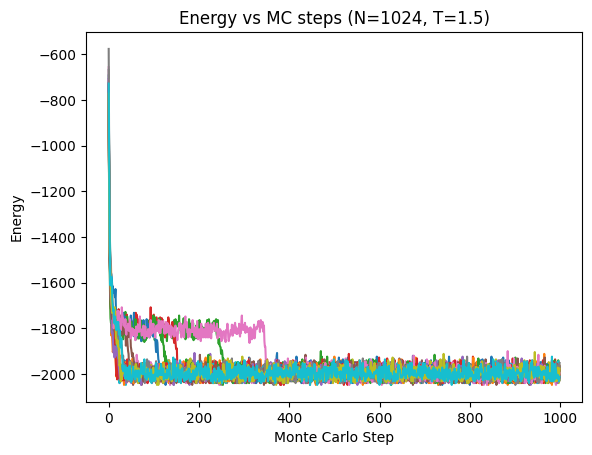

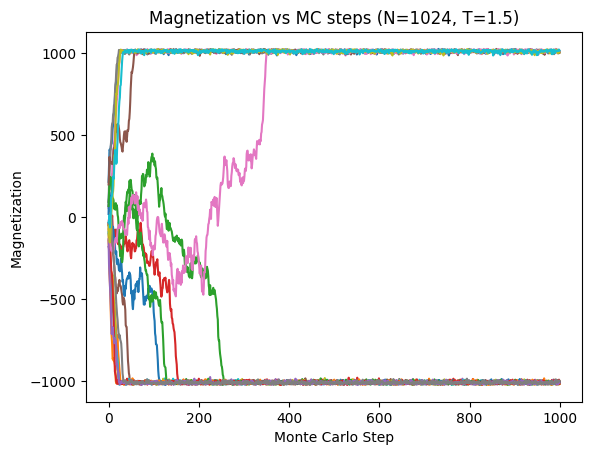

In [15]:
systems, magnetizations, N, T = generate_systems(n_systems=20)
plot_systems_energy(systems, magnetizations, N, T)

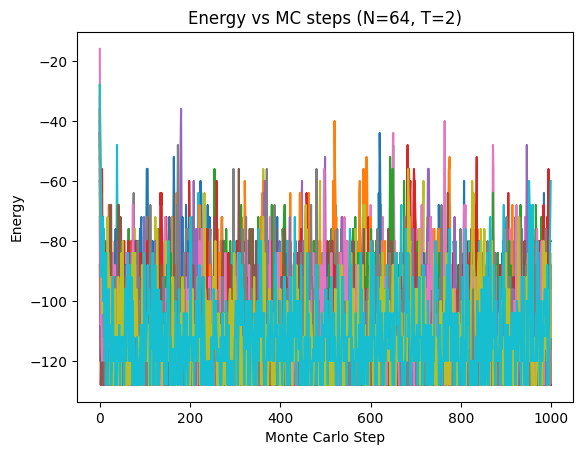

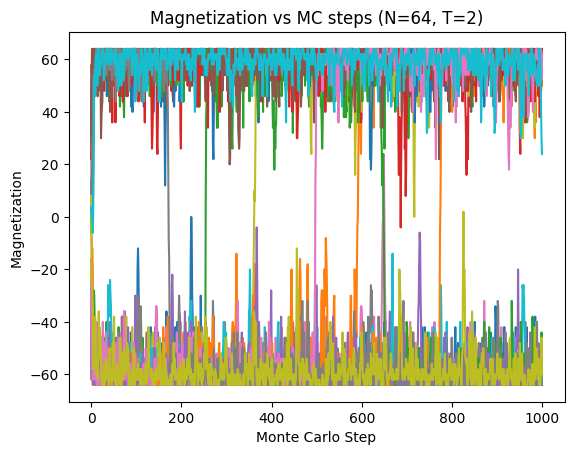

In [61]:
systems, magnetizations, N, T = generate_systems(N=64, T=2, n_systems=20, mc_steps=1000)
plot_systems_energy(systems, magnetizations, N, T, mc_steps=1000)

### Conclusões
Primeiramente, é preciso levar em conta que o método estudado de Algoritmo de Metropolis para modelo Ising 2D se utiliza do método de Monte Carlo, o qual é estocástico, isto é, ele utiliza números aleatórios - nesse contexto - para decidir se um flip será aceito ou não. Portanto, o estado final do sistema será uma aproximação do estado de equilíbrio. Quanto maior o número de iterações, mais próximo do estado de equilíbrio o sistema estará. Além disso, o estado inicial gerado randomicamente impacta diretamente no resultado final. Isto posto, é notável que mesmo para configurações iguais, a quantidade de passos pode variar consideravelmente, cabendo ao analista decidir qual é o número deles que podem ser descartar no início de uma simulação para atingirmos um estado estacionário de maneira segura e eficaz.

A seguir está apresentada a análise dos experimentos:
Durante a geração de sistemas, podemos observar que o tamanho do sistema é proporcional a quantidade de passos de Monte Carlo necessários para se chegar no equilíbrio. A maioria dos sistemas converge de maneira similar, porém deve-se ter o cuidado de perceber que há casos em que há uma grande variação no número de passos necessários para se chegar no equilíbrio, tornando necessária uma abordagem mais cautelosa para se determinar o número de iterações que devem ser descartadas no início da simulação.

Um fator que muda drasticamente o comportamento observado é a temperatura. Sistemas nos quais esta apresenta valores mais elevados tendem a ser mais confusos e apresentam grande variação tanto da energia quanto da magnetização. Isso occorre porque a temperatura é diretamente proporcional a energia do sistema, e quanto maior a energia, maior a probabilidade de se encontrar o sistema em um estado de alta energia. Isso faz com que o sistema apresente uma grande variação de energia e magnetização, tornando mais difícil a identificação do estado de equilíbrio. Uma temperatura mais baixa apresenta maior demora para que o sistema atinja o equilíbrio, porém apresenta uma variação menor da energia e da magnetização. 

Abaixo segue uma tabela com alguns resultados encontrados, onde os valores dizem respeito ao número aproximado de passos de Monte Carlo necessários para se atingir o equilíbrio:




In [67]:
N = [100, 100, 100, 81, 81, 81, 64, 64, 64, 1024]
T = [1.5, 0.7, 2.0, 0.5, 1.5, 2.0, 0.8, 1.5, 2.0, 1.5]
steps = [50, 550, 30, '+1000', 30, 30, 100, 30, 30, 600]

df = pd.DataFrame({'Número de spins': N, 'Temperatura': T, 'Passos até a estabilização': steps})
df.index.name = 'Experimento'
df

,Número de spins,Temperatura,Passos até a estabilização
Experimento,,,
0,100,1.5,50
1,100,0.7,550
2,100,2.0,30
3,81,0.5,+1000
4,81,1.5,30
5,81,2.0,30
6,64,0.8,100
7,64,1.5,30
8,64,2.0,30
